In [13]:
import math
import numpy as np
import scipy
from matplotlib import pyplot as plt
from math import pi


def normalize(vec):
  return vec / np.linalg.norm(vec)


def random_point_on_a_sphere(n):
  return normalize(np.random.normal(0, 1, n))


def gs(vecs):
  proj = lambda of, on: np.dot(of, on) / np.dot(on, on) * on
  e = []

  for vec in vecs:
    e.append(normalize(vec - np.sum([proj(vec, ej) for ej in e], axis=0)))
  
  return e


def build_onb(vec, eps=1e-6):
  n = len(vec)
  E = [np.array([int(i == j) for j in range(n)]) for i in range(n)]
  E.pop(next(i for i, x in enumerate(vec) if not abs(x) < eps))
  return gs([vec, *E])


def random_elipsoid(n, S, sigma_dist, p):
  sigma = np.diag(sigma_dist(n) ** 2)

  e = np.column_stack(build_onb(random_point_on_a_sphere(n)))
  c = math.sqrt(2 * scipy.special.gammaincinv(n / 2, p))
  l = c * sigma ** 0.5

  X = np.random.multivariate_normal(np.zeros(n), e @ sigma @ e.transpose(), S)

  return X, e, l, np.zeros(n)


In [14]:
# Возвращаетъ коэффиціентъ, на который нужно растянуть пространство для избавленія отъ коллизіи. Значеніе 1 означаетъ, что коллизіи нѣтъ.
def calculate_t_value_for_colision(first_ellipse, second_ellipse):
  _, l1, c1 = first_ellipse
  _, l2, c2 = second_ellipse

  # Сферическая коллизія:
  r1 = l1.diagonal().max()
  r2 = l2.diagonal().max()
  t_sphere = (r1 + r2) / np.linalg.norm(c1 - c2)

  if t_sphere <= 1:
    return 1
  
  # TODO: элипсоидная коллизія

  return t_sphere


# NOTE: Въ случаѣ съ одномѣрнымъ кластерингомъ, всё ломается при s = [1, 1, 1] и w = [1, 1, 1] по понятнымъ причинамъ
#       Ну, тутъ, собственно, ничего и не сдѣлать...
def generate_clusters(n, sizes, cluster_weights, d=0.7, p=0.85, probes_cnt=1000):
  sigma_dist=lambda n : np.random.uniform(1 - d, 1 + d, n)

  clusters = []
  N = sum(sizes)
  K = len(sizes)
  alpha = None

  for i in range(K):
    S = sizes[i]
    a = cluster_weights[i]
    X, e, l, _ = random_elipsoid(n, S, sigma_dist, p)

    if i == 0:
      dist = 2 * l.diagonal().max()
      alpha = S * dist ** 2 / a
      c = dist * random_point_on_a_sphere(n)
    
    else:
      dist = math.sqrt(alpha * a / S)

      # Пробированіе
      opt_probe = None

      for _ in range(probes_cnt):
        c = dist * random_point_on_a_sphere(n)

        # Ищемъ t-значенія для пересѣченій
        t = max([calculate_t_value_for_colision((e, l, c), (ei, li, ci)) for _, ei, li, ci in clusters])

        if t <= 1:
          opt_probe = None
          break

        elif opt_probe is None or t < opt_probe[0]:
          opt_probe = (t, c)

      # Процедура rescaling'а:
      if opt_probe is not None:
        t, c = opt_probe
        t *= 1.05 # Домножаемъ на коэффиціентъ для того, чтобы развести кластеры чуть дальше другъ отъ друга
        print("COLLISION: t = {}".format(t))
        clusters = [(X, e, l, c * t) for X, e, l, c in clusters]
        alpha *= t ** 2
        c *= t

    clusters.append((X, e, l, c))

  return [(X + c, e, l, c) for X, e, l, c in clusters]

In [15]:
def draw_clusters(n, clusters):
  if n == 2:
    plt.axis('equal')
    plt.grid(color='lightgray', linestyle='--')

    for X, e, l, c in clusters:
      points_cnt = 100
      t = np.linspace(0, 2 * pi, points_cnt)

      ellipse = np.column_stack([c] * points_cnt) + e @ l @ np.array([np.cos(t), np.sin(t)])
      plt.plot(*ellipse)

      plt.scatter(*X.transpose(), s=0.3)

    plt.show()
    
  elif n == 3:
    ax = plt.axes(projection="3d")
    
    for X, e, l, c in clusters:
      u = np.linspace(0, 2 * np.pi, 100)
      v = np.linspace(0, np.pi, 100)

      x = l.diagonal()[0] * np.outer(np.cos(u), np.sin(v))
      y = l.diagonal()[1] * np.outer(np.sin(u), np.sin(v))
      z = l.diagonal()[2] * np.outer(np.ones_like(u), np.cos(v))
      
      for i in range(len(x)):
        for j in range(len(x)):
          [x[i,j], y[i,j], z[i,j]] = e @ [x[i,j], y[i,j], z[i,j]] + c

      ax.plot_surface(x, y, z, rstride=4, cstride=4, alpha=0.3)

      ax.scatter3D(*X.transpose(), s=0.3)

    plt.show()
    ax.azim = 60
    ax.elev = 30
    plt.show()

Generated clusters expected: 1.00, 1.00, 1.00, 1.00, 2.00, 2.00, 2.00
Generated clusters weights: 1.00, 1.00, 3.00, 1.98


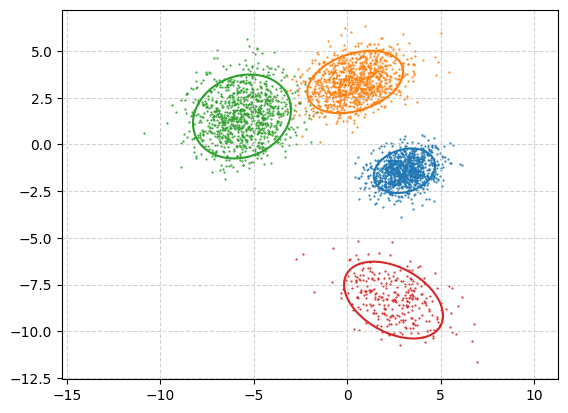

In [16]:
n = 2
sizes = [1000] * 3 + [300]
weights = [1, 1, 3, 2]
clusters = generate_clusters(n, sizes, weights, p=0.8, probes_cnt=1000)

real_w = [len(cluster[0]) * np.linalg.norm(cluster[0].mean(axis=0)) ** 2 for cluster in clusters]
real_w /= min(real_w)

print("Generated clusters expected: {}".format(", ".join(["{:0.2f}".format(wi) for wi in [1, 1, 1, 1, 2, 2, 2]])))
print("Generated clusters weights: {}".format(", ".join(["{:0.2f}".format(wi) for wi in real_w])))

draw_clusters(n, clusters)